<a href="https://colab.research.google.com/github/surajpreetham/Data_science_codes/blob/main/sentiment_practice_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import LancasterStemmer
from bs4 import BeautifulSoup
import spacy
import re,unicodedata,string
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob,Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [33]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('IMDB Dataset.csv',engine='python')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df.shape

(50000, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.columns

In [12]:
train_reviews = df[:40000]
train_sentiments = df[:40000]
test_reviews = df[40000:]
test_sentiments = df[40000:]

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
tokenizer = ToktokTokenizer()
stopwords_list = nltk.corpus.stopwords.words('english')

Removing Html strips and noise reduction

In [17]:
def strip_html(text):
  soup = BeautifulSoup(text,"html.parser")
  return soup.get_text()

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]','',text)

def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  return text
  
df['review'] = df['review'].apply(denoise_text)

Removing special characters


In [19]:
def remove_special_characters(text,remove_digits=True):
  pattern = r'[^a-zA-Z0-9\s]'
  text = re.sub(pattern,'',text)
  return text

df['review'] = df['review'].apply(remove_special_characters)

Text Stemming

In [20]:
def simpleStemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

df['review'] = df['review'].apply(simpleStemmer)

Removing Stopwords

In [21]:
stopwords = set(stopwords.words('english'))

def remove_stopwords(text,is_lower_case=False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

df['review'] = df['review'].apply(remove_stopwords)

Normalised train and test reviews checking samples

In [22]:
norm_train_reviews = df.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [23]:
norm_test_reviews=df.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

Bag of Words

In [24]:
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_reviews = cv.fit_transform(norm_train_reviews)
cv_test_reviews = cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6208633)
BOW_cv_test: (10000, 6208633)


Tf-idf

In [28]:
tv = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_reviews = tv.fit_transform(norm_train_reviews)
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6208633)
Tfidf_test: (10000, 6208633)


Labeling the sentiment text

In [30]:
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


Sentiments train test split

In [31]:
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]

Modelling the dataset

In [32]:
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
lr_bow = lr.fit(cv_train_reviews,train_sentiments) #From Bag of Words
print(lr_bow)

lr_tfidf = lr.fit(tv_train_reviews,train_sentiments) #TFIDF 
print(lr_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


Logistic Regression Model and Model performance

In [34]:
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


Accuracy of the model

In [35]:
lr_bow_score = accuracy_score(test_sentiments,lr_bow_predict)
print(lr_bow_score)
lr_tfidf_score = accuracy_score(test_sentiments,lr_tfidf_predict)
print(lr_tfidf_score)

0.7514
0.7498


Classification Report

In [36]:
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)
lr_tfidf_report = classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Confusion Matrix

In [37]:
cm_bow = confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
cm_tfidf = confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3770 1237]
 [1249 3744]]
[[3662 1345]
 [1157 3836]]


Stochastic gradient descent or Linear support vector machines for bag 
of words and tfidf features

In [38]:
svm = SGDClassifier(loss='hinge',max_iter=500,random_state=42)
svm_bow = svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
svm_tfidf = svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


Model performance on test data

In [39]:
svm_bow_predict = svm.predict(cv_test_reviews)
print(svm_bow_predict)
svm_tfidf_predict = svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


Accuracy of the model

In [40]:
svm_bow_score = accuracy_score(test_sentiments,svm_bow_predict)
print(svm_bow_score)
svm_tfidf_score = accuracy_score(test_sentiments,svm_tfidf_predict)
print(svm_tfidf_score)

0.583
0.5112


Classification report

In [42]:
svm_bow_report = classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
svm_tfidf_report = classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)


              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



Confusion Matrix

In [43]:
cm_bow = confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
cm_tfidf = confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4947   60]
 [4110  883]]
[[5007    0]
 [4888  105]]


Naive Bayes 

In [44]:
mnb = MultinomialNB()
mnb_bow = mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
mnb_tfidf = mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


Model the performance of the Naive Bayes

In [45]:
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


Accuracy of the model

In [46]:
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7474
mnb_tfidf_score : 0.7474


Classification Report

In [47]:
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.74      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.74      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Confusion Matrix

In [48]:
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3642 1365]
 [1161 3832]]
[[3642 1365]
 [1161 3832]]


WordCloud

WordCloud for Positive Review words

In [ ]:
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

In [51]:
norm_train_reviews[2]

'thought thi wa wonder way spend time hot summer weekend sit air condit theater watch lightheart comedi plot simplist dialogu witti charact likabl even well bread suspect serial killer may disappoint realiz thi match point 2 risk addict thought wa proof woodi allen still fulli control style mani us grown lovethi wa id laugh one woodi comedi year dare say decad ive never impress scarlet johanson thi manag tone sexi imag jump right averag spirit young womanthi may crown jewel hi career wa wittier devil wear prada interest superman great comedi go see friend'

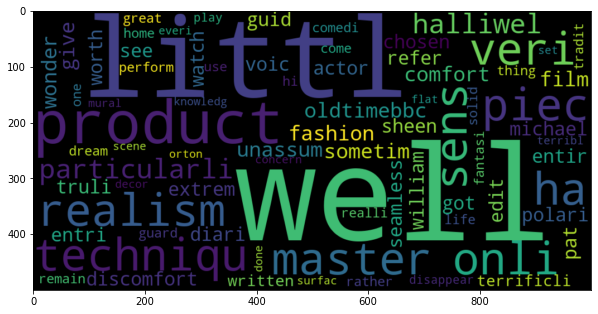

In [53]:
plt.figure(figsize=(10,10))
positive_text = norm_train_reviews[1]
WC = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

<function matplotlib.pyplot.show>

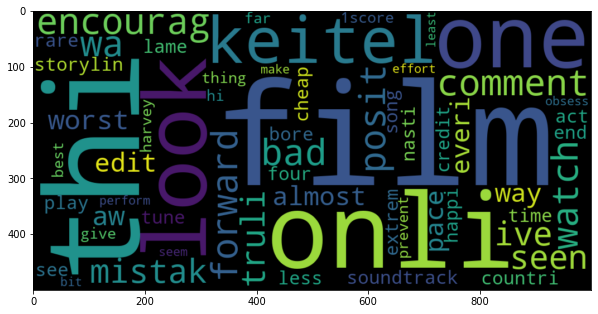

In [54]:
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector machines.
Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.